### Notebook to detect identical Genotypes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import socket as socket
import os as os
import sys as sys
import multiprocessing as mp
import h5py
import allel

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/hapBLOCK/"  # The Path on Harvard Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)

print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

compute-a-17-99.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/hapBLOCK
CPU Count: 32


In [2]:
def get_idx_iid(f,sample, unique=True):
    """Return Index of sample samples in hdf5 f"""
    samples = pd.Series(f["samples"][:])
    idx = samples.str.contains(sample)
    idx = np.where(idx)[0]
    if unique:
        assert(len(idx)==1)
        return idx[0]
    else:
        return idx
    
def get_exact_idx_iid(f,sample, unique=True):
    """Return Index of sample samples in hdf5 f"""
    samples = pd.Series(f["samples"][:])
    idx = samples==sample
    idx = np.where(idx)[0]
    assert(len(idx)==1)
    return idx
    
def get_coverage(f, j):
    """Get Coverage of sample j in hdf5 f"""
    ads =  f["calldata/AD"][:,j,:]
    ads[ads<0]=0
    cov = np.mean(ads)*2
    return cov

def get_markers_good(f, j, output=True, cutoff=0.99):
    """Get markers"""
    m = np.max(f["calldata/GP"][:,j,:], axis=1)
    idx = (m>cutoff)
    if output:
        c1 = np.mean(m>cutoff)
        print(f"Filtering to {cutoff} GP variants: {c1:.3f}x")
    return idx

def get_fraction_identical(f, sample1="SUC006", sample2="R26.SG", 
                           gp_cutoff=0, cutoff=0.98, output=False):
    """Get Fraction of Identical Genotype Configurations"""
    j1 = get_exact_idx_iid(f, sample1)[0]
    j2 = get_exact_idx_iid(f, sample2)[0]
    
    idx1 = get_markers_good(f, j1, cutoff=cutoff, output=output)
    idx2 = get_markers_good(f, j2, cutoff=cutoff, output=output)
    idx = (idx1 & idx2)
    snp_frac = np.mean(idx)
    if output:
        print(f"Filtering to common GP variants: {snp_frac:.3f}x")
    
    gt1 = f["calldata/GT"][:, j1, :][idx,:]
    gt2 = f["calldata/GT"][:, j2, :][idx,:]
    g1, g2 = np.sum(gt1, axis=1), np.sum(gt2, axis=1)
    frac_same = np.mean(g1 == g2)
    return frac_same,snp_frac

# Calculate Fraction Identical for all individuals in list of pairs
Run one time

In [3]:
df = pd.read_csv("./output/dumpster/full_run_ch3_9813/o_homo_all_0005.tsv", sep="\t")
print(f"Loaded {len(df)} PO or identical Individuals")

Loaded 1603 PO or identical Individuals


In [58]:
%%time
f = h5py.File(f"./data/hdf5/1240k_v43/ch{ch}.h5", "r") # Load for Sanity Check. See below!
y = [get_fraction_identical(f, sample1=iid1, sample2=iid2, cutoff=0.98)
                                     for iid1, iid2 in df[["iid1","iid2"]].values]
y=np.array(y)
identical=y[:,0]
snp_frac=y[:,1]
f.close()

CPU times: user 11min 17s, sys: 1min 42s, total: 12min 59s
Wall time: 13min 34s


In [59]:
df["gt_match_rate_ch3"] = identical
df["frac_snps_good_ch3"] = snp_frac

In [ ]:
df.sort_values(by="gt_match_rate_ch3", ascending=False)[:30]

In [19]:
savepath ="./output/relatives_snp/opp_homos_ch3.tsv"
df.to_csv(savepath, sep="\t", index=False)
print(f"Saved {len(df)} opp. homo pairs to {savepath}")

Saved 1603 opp. homo pairs to ./output/relatives_snp/opp_homos_ch3.tsv


# Process the similarity list

In [20]:
savepath ="./output/relatives_snp/opp_homos_ch3.tsv"
df = pd.read_csv(savepath, sep="\t")

In [22]:
idx_identical = df["gt_match_rate_ch3"]>0.98
print(f"Found identical indivdiuals {np.sum(idx_identical)}")

Found identical indivdiuals 1179


In [23]:
df

,iid1,iid2,opp_homo_rate_ch3,gt_match_rate_ch3,frac_snps_good_ch3
0,I2497_all,I2497,0.000000,0.997922,0.483048
1,I4451_all,I4451,0.000000,0.999860,0.697437
2,I2960,I2959,0.000162,0.824306,0.604685
3,I3962,I3836,0.000000,0.998604,0.806810
4,I4246_published,I4246,0.000000,1.000000,0.754841
...,...,...,...,...,...
1598,SFI-43.SG,SFI-44.SG,0.000143,0.771381,0.854667
1599,PER503.SG,PER3123.SG,0.000034,0.849570,0.720888
1600,KPT002_petrous,UKY001,0.000000,1.000000,0.804974
1601,LJM3,LJM5,0.000026,0.797373,0.931923


# Area 51

### Plot identical individuals

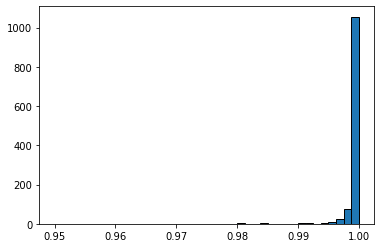

In [71]:
bins=np.linspace(0.95,1,41)
plt.figure()
ax=plt.gca()
ax.hist(df["gt_match_rate_ch3"], ec="k",bins=bins)
plt.show()